In [ ]:
cd ..

In [2]:
from workflow_array_ephys.pipeline import session, ephys, trial, event

Connecting ttngu207@dss-db.datajoint.io:3306


In [3]:
from workflow_array_ephys import analysis

# Event-aligned trialized unit spike times

The `analysis` schema provides example tables to perform event-aligned spike-times analysis.
+ ***SpikesAlignmentCondition*** - a manual table to specify the inputs and condition for the analysis
+ ***SpikesAlignment*** - a computed table to extract event-aligned spikes and compute unit PSTH

Let's start by creating several analyses configuration - i.e. inserting into ***SpikesAlignmentCondition***

In [4]:
ephys.CuratedClustering()

subject,session_id,insertion_number,paramset_idx
subject5,1,1,0
subject5,1,2,0


In [4]:
clustering_key = (ephys.CuratedClustering & {'subject': 'subject5', 'session_id': 1, 'insertion_number': 1}).fetch1('KEY')

In [6]:
event.AlignmentEvent()

alignment_name,alignment_description,alignment_event_type,alignment_time_shift (s) WRT alignment_event_type,start_event_type,start_time_shift (s) WRT start_event_type,end_event_type,end_time_shift (s) WRT end_event_type
center_button,,center,0.0,center,-3.0,center,3.0
left_button,,left,0.0,left,-3.0,left,3.0
right_button,,right,0.0,right,-3.0,right,3.0


In [5]:
alignment_key = (event.AlignmentEvent & 'alignment_name = "center_button"').fetch1('KEY')

In [8]:
trial.Trial & clustering_key

subject,session_id,trial_id trial number (1-based indexing),trial_type,trial_start_time (second) relative to recording start,trial_stop_time (second) relative to recording start
subject5,1,1,stim,2.043,10.043
subject5,1,2,ctrl,10.508,18.508
subject5,1,3,ctrl,18.7,26.7
subject5,1,4,ctrl,26.707,34.707
subject5,1,5,stim,34.715,42.715
subject5,1,6,stim,42.806,50.806
subject5,1,7,ctrl,50.839,58.839
subject5,1,8,ctrl,59.196,67.196
subject5,1,9,stim,67.31,75.31
subject5,1,10,ctrl,75.772,83.772


In [30]:
ctrl_trials = trial.Trial & clustering_key & 'trial_type = "ctrl"'

In [33]:
alignment_condition = {**clustering_key, **alignment_key, 'trial_condition': 'ctrl_center_button'}

In [34]:
analysis.SpikesAlignmentCondition.insert1(alignment_condition, skip_duplicates=True)

In [35]:
analysis.SpikesAlignmentCondition.Trial.insert(
    (analysis.SpikesAlignmentCondition * ctrl_trials & alignment_condition).proj(),
    skip_duplicates=True)

With the steps above, we have create a new spike alignment condition for analysis, named `ctrl_center_button`, which specifies:
+ a CuratedClustering of interest for analysis
+ an event of interest to align the spikes to - `center_button`
+ a set of trials of interest to perform the analysis on - `ctrl` trials

Now, let's create another set with:
+ the same CuratedClustering of interest for analysis
+ an event of interest to align the spikes to - `center_button`
+ a set of trials of interest to perform the analysis on - `stim` trials

In [37]:
stim_trials = trial.Trial & clustering_key & 'trial_type = "stim"'
alignment_condition = {**clustering_key, **alignment_key, 'trial_condition': 'stim_center_button'}
analysis.SpikesAlignmentCondition.insert1(alignment_condition, skip_duplicates=True)
analysis.SpikesAlignmentCondition.Trial.insert(
    (analysis.SpikesAlignmentCondition * stim_trials & alignment_condition).proj(),
    skip_duplicates=True)

In [38]:
analysis.SpikesAlignmentCondition()

subject,session_id,insertion_number,paramset_idx,alignment_name,trial_condition user-friendly name of condition,bin_size bin-size (in second) used to compute the PSTH
subject5,1,1,0,center_button,ctrl_center_button,0.04
subject5,1,1,0,center_button,stim_center_button,0.04


In [40]:
analysis.SpikesAlignmentCondition.Trial & 'trial_condition = "ctrl_center_button"'

subject,session_id,insertion_number,paramset_idx,alignment_name,trial_condition user-friendly name of condition,trial_id trial number (1-based indexing)
subject5,1,1,0,center_button,ctrl_center_button,2
subject5,1,1,0,center_button,ctrl_center_button,3
subject5,1,1,0,center_button,ctrl_center_button,4
subject5,1,1,0,center_button,ctrl_center_button,7
subject5,1,1,0,center_button,ctrl_center_button,8
subject5,1,1,0,center_button,ctrl_center_button,10
subject5,1,1,0,center_button,ctrl_center_button,17
subject5,1,1,0,center_button,ctrl_center_button,19
subject5,1,1,0,center_button,ctrl_center_button,21
subject5,1,1,0,center_button,ctrl_center_button,22


### Now let's run the computation on these

In [42]:
analysis.SpikesAlignment.populate(display_progress=True)

SpikesAlignment: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:13<00:00,  6.97s/it]


### Let's visualize the results

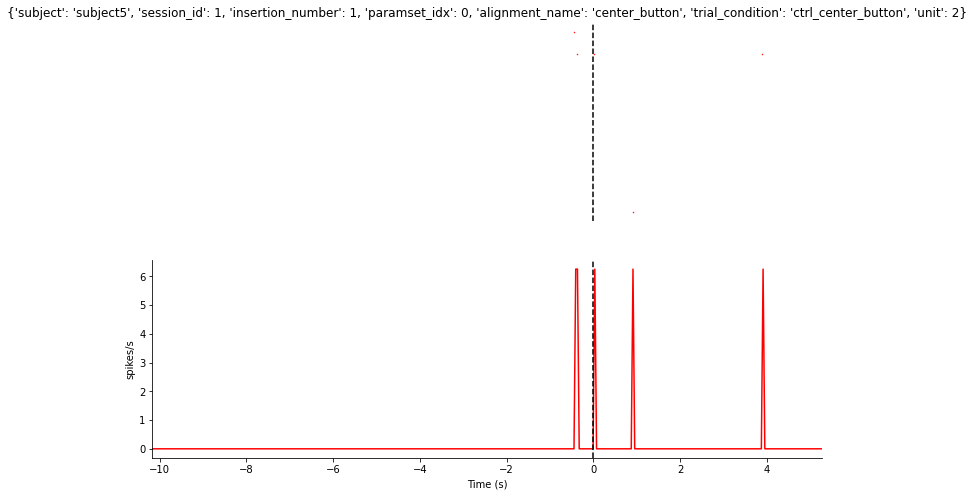

In [7]:
alignment_condition = {**clustering_key, **alignment_key, 'trial_condition': 'ctrl_center_button'}
analysis.SpikesAlignment().plot_raster(alignment_condition, unit=2);

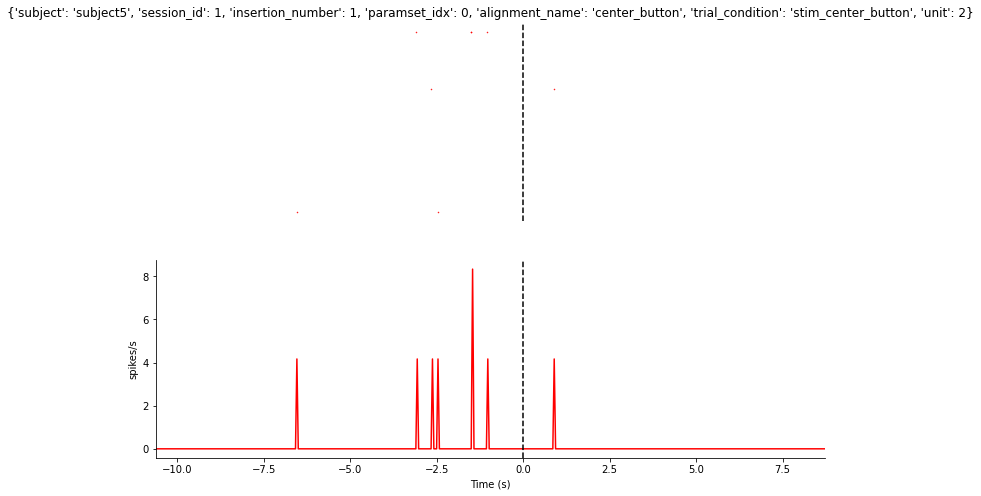

In [6]:
alignment_condition = {**clustering_key, **alignment_key, 'trial_condition': 'stim_center_button'}
analysis.SpikesAlignment().plot_raster(alignment_condition, unit=2);